## Домашняя работа #5.

**Kaggle: [competition](https://www.kaggle.com/competitions/hse-2023-hw-5), [invite link](https://www.kaggle.com/t/6d51db6f2dde497a9c12ecf28899082f)**

**Kaggle deadline: 06/10/2023 12:59 PM UTC**

**Hard deadline: 11.06.2023 03:00:00 +0003 GMT**

### Описание

Вам предоставлен измененный датасет CIFAR10. В нём содержится 50+10 тысяч RGB изображений размера 32х32 следующих 10 классов: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

Задача: используя свёрточные нейронные сети, добиться максимальной точности классификации.

### Данные

В данном ноутбуке уже есть код для PyTorch, отвечающий за загрузку данных. Если будете использовать этот фреймворк, можно пропустить секцию. Если же хочется использовать другой фреймворк глубокого обучения, ниже дано краткое описание формата хранения данных.

Каждый из файлов — сериализованный с помощью pickle c 4ой версией протолока python-словарик.

Список файлов:

- `meta` — метаданные датасета (например, названия классов)
- `data_train` — данные обучения, 50к примеров, по 5к на один класс
- `data_test` — данные теста, 10к примеров, по 1к на один класс, без ground-truth классов

Словарики с данными имеют следующие поля:

- `section` — имя части данных (обучение/тест)
- `names` — хеш-идентификаторы объекта
- `labels` — ground-truth классы, список из N чисел от 0 до 9
- `images` — numpy массив размером `(N, 3*32*32)` с изображениями

### Оценка

Качество решения будет оцениваться по метрике "точность". Точность – это количество правильно классифицированных картинок к общему числу картинок в тестовом наборе. Публичный лидерборд рассчитывается по 30% тестовых данных, поэтому старайтесь не переобучаться под него.

```
accuracy = (correct classified) / (total # of examples)
```

В качестве решения вы должны прислать файл формата:

```
Id,Category
0, 3
1, 2
2, 9
3, 1
...
```

где:

- `Id` — порядковый номер объекта в тестовом датасете
- `Category` — предсказанный класс объекта

В данном ноутбуке уже есть код, подготавливающий файл решения.

Итоговая оценка складывается из двух:
- по 5 баллов за преодоление каждого из бенчмарков (от 0 до 15 баллов)
- от 0 до 15 баллов за сам код решения

### Эксперименты

Так как в обучении нейросетевой модели есть очень много различных гиперпараметров, в данном домашнем задании нужно будет делать много различных экспериментов. И будет очень полезно, и для вас самих, и для нас, проверяющих, наличие текстового описания всех, или по крайней мере самых интересных / важных в выборе итоговой модели, экспериментов с результатами в финальном ноутбуке. Наличие и подробность описания экспериментов будут входить в итоговую оценку за домашнее задание. Дедлайн на Kaggle специально поставлен немного раньше, чтобы у вас было время спокойно дописать отчет об экспериментах.

## Решение

### Для решения использовался resnet18 и resnet34.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [ ]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms as tr
# from torchvision.transforms import ToTensor, Compose
from torchvision.datasets.vision import VisionDataset

Данные лежат в секции [Data](https://www.kaggle.com/c/csc-cv21-hw5/data) kaggle-соревнования. <br>
Нужно скачать архив с данными и расспаковать его. <br>
В переменной ниже надо указать путь до датасета. <br>

In [ ]:
dataset_root = "data"

Код для загрузки измененного датасета CIFAR10. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [ ]:
class CIFAR10(VisionDataset):

    def __init__(self,
                 root: str,
                 train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images'].reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index])
        target = self.targets[index] if self.targets else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Загрузка датасета

### Разные трансформы, т.к. resnet18 неглубокий и для него не нужен resize. Трансформы, которые закомментированы, ощутимого эффекта не дали.

Загружаем часть датасета для обучения.

In [ ]:
def transform_train(img):
    return tr.Compose([
        tr.RandomCrop(32, padding=4),
        tr.RandomHorizontalFlip(),
        #
        # tr.RandomRotation(7),
        # tr.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        # tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        #
        tr.ToTensor(),
        tr.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])(img)

In [ ]:
def transform_train34(img):
    return tr.Compose([
        tr.Resize((224,224)),
        tr.RandomCrop(224, padding=28),
        # tr.RandomCrop(32, padding=4),
        tr.RandomHorizontalFlip(),
        #
        # tr.RandomRotation(7),
        # tr.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        # tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        #
        tr.ToTensor(),
        tr.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])(img)

In [ ]:
data = CIFAR10(
    root=dataset_root,
    train=True,
    #transform=ToTensor(),
    transform = transform_train34
)

Разбиваем случайным образом датасет на обучение и валидацию. <br>
На первой части будем обучать модель классификации. <br>
На второй части будем оценивать качество во время экспериментов. <br>

In [ ]:
train_data, val_data = torch.utils.data.random_split(
    data,
    [40000, 10000],
    generator=torch.Generator().manual_seed(42),
)

Инициализируем data loader-ы.

In [ ]:
batch_size = 512 #64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Посмотрим, какой размерности батчи выдает data loader.

In [ ]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([512, 3, 224, 224])
Shape of y:  torch.Size([512]) torch.int64


### Модель классификации

Определяем, на каком устройстве будем обучать модель.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Задаем архитектуру модели классификации. <br>
Тут большой простор для разных экспериментов. <br>

### ниже реализация архитектуры resnet34

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_c, out_c, downsample=False):
        super().__init__()

        if downsample:
            self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential(nn.Identity())


        self.block_net = nn.Sequential(
            self.conv1,
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.block_net(x)
        out = out + shortcut
        return nn.ReLU()(out)

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, in_c, outputs=10):
        super().__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(in_c, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64),
            ResNetBlock(64, 64)
        )

        self.layer2 = nn.Sequential(
            ResNetBlock(64, 128, downsample=True),
            ResNetBlock(128, 128),
            ResNetBlock(128, 128),
            ResNetBlock(128, 128)
        )

        self.layer3 = nn.Sequential(
            ResNetBlock(128, 256, downsample=True),
            ResNetBlock(256, 256),
            ResNetBlock(256, 256),
            ResNetBlock(256, 256),
            ResNetBlock(256, 256),
            ResNetBlock(256, 256)
        )

        self.layer4 = nn.Sequential(
            ResNetBlock(256, 512, downsample=True),
            ResNetBlock(512, 512),
            ResNetBlock(512, 512)
        )

        self.last_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(512, outputs),
            #nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.layer0(x)
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = self.last_layer(x)
        #print(x.shape)

        return x

In [ ]:
X,y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

In [ ]:
r34 = ResNet34(3)
c = r34(X)

torch.Size([512, 64, 56, 56])


### ниже имплементация resnet18. Две версии - класссическая и с ELU. Прочитал в статье, что если поменять BatchNorm+ReLu на ELU, то будет лучше. Но на результат это не повлияло особо. Думаю, просто слишком неглубокая сеть.

In [ ]:
class ResNetBlockELU(nn.Module):
    def __init__(self, in_c, out_c, downsample=False):
        super().__init__()

        if downsample:
            self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential(nn.Identity())


        self.block_net = nn.Sequential(
            self.conv1,
            # nn.BatchNorm2d(out_c),
            # nn.ReLU(),
            nn.ELU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            #nn.ReLU()
        )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.block_net(x)
        out = out + shortcut
        #return nn.ReLU()(out)
        return out

In [ ]:
class ResNet18ELU(nn.Module):
    def __init__(self, in_c, outputs=10):
        super().__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(in_c, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = nn.Sequential(
            ResNetBlockELU(64, 64),
            ResNetBlockELU(64, 64)
        )

        self.layer2 = nn.Sequential(
            ResNetBlockELU(64, 128, downsample=True),
            ResNetBlockELU(128, 128)
        )

        self.layer3 = nn.Sequential(
            ResNetBlockELU(128, 256, downsample=True),
            ResNetBlockELU(256, 256)
        )

        self.layer4 = nn.Sequential(
            ResNetBlockELU(256, 512, downsample=True),
            ResNetBlockELU(512, 512)
        )

        self.last_layer = nn.Sequential(
            nn.ELU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(512, outputs),
            #nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.layer0(x)
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = self.last_layer(x)

        return x

In [ ]:
X,y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([2048, 3, 32, 32]), torch.Size([2048]))

In [ ]:
r18 = ResNet18ELU(3)
c = r18(X)

In [ ]:
c.shape

torch.Size([1024, 10])

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_c, out_c, downsample=False):
        super().__init__()

        if downsample:
            self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential(nn.Identity())


        self.block_net = nn.Sequential(
            self.conv1,
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.block_net(x)
        out = out + shortcut
        return nn.ReLU()(out)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_c, outputs=10):
        super().__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(in_c, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64)
        )

        self.layer2 = nn.Sequential(
            ResNetBlock(64, 128, downsample=True),
            ResNetBlock(128, 128)
        )

        self.layer3 = nn.Sequential(
            ResNetBlock(128, 256, downsample=True),
            ResNetBlock(256, 256)
        )

        self.layer4 = nn.Sequential(
            ResNetBlock(256, 512, downsample=True),
            ResNetBlock(512, 512)
        )

        self.last_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(512, outputs),
            #nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.layer0(x)
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = self.last_layer(x)

        return x

In [ ]:
# X,y = next(iter(train_dataloader))
# X.shape, y.shape

In [ ]:
# r18 = ResNet18(3)
# c = r18(X)

In [ ]:
# c.shape

In [ ]:
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(3*32*32, 10),
# )
#model = ResNet18(in_c=3)
model = ResNet18ELU(in_c=3)

Отправляем модель на выбранное устройство.

In [ ]:
model = model.to(device)
print(model)

ResNet18ELU(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResNetBlockELU(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Identity()
      )
      (block_net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBlockELU(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Identity()
      )
      (block

### Обучение

Задаем функцию потерь (цель оптимизации) и оптимизатор.

### использовал Adam с weight_decay и без

In [ ]:
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

### Шедулера изначально не было, с ним результат лучше. Пробовал с параметрами по умолчанию и со своими - разницы особо нет.

In [ ]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Код для визуализации процесса обучения.

Каждые `interval` шагов оптимизации и в конце эпох мы записываем значения функции потерь и метрик в лог. <br>
Затем вызовом функции `show_progress` обновляем график обучения. <br>

In [ ]:
# Training logs
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [ ]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show()

### пробовал добавить градиентный клиппинг - результат не изменился

In [ ]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        ###
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        ###
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [ ]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    ###
    scheduler.step(test_loss)
    ###
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

### самая первая версия без шедулера

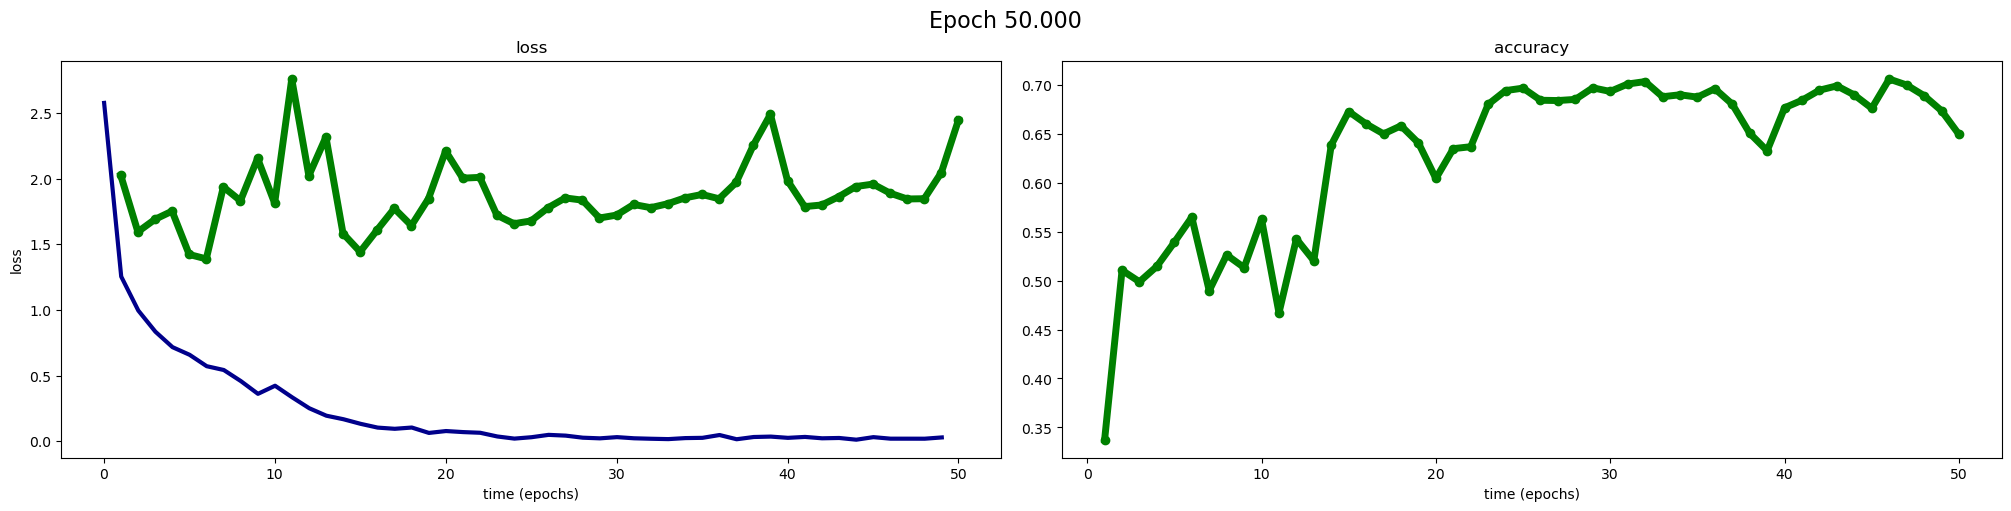

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [51:29<00:00, 61.78s/it]


In [ ]:
epochs = 50
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### добавим шедулер - сошлось бысрее, результат лучше

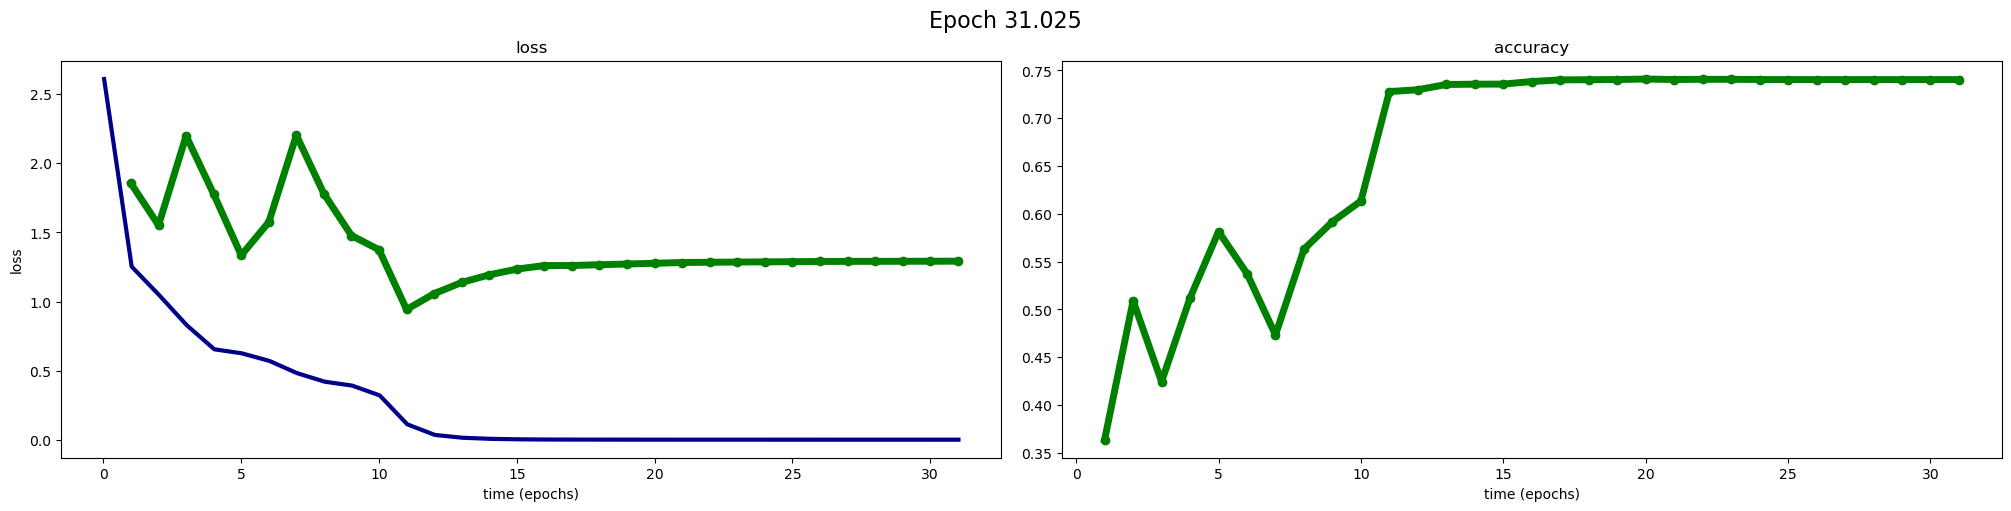

 62%|██████████████████████████████████████████████████▊                               | 31/50 [32:57<20:11, 63.78s/it]


KeyboardInterrupt: 

In [ ]:
epochs = 50
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### добавим трансформы к изображениям - результат еще лучше

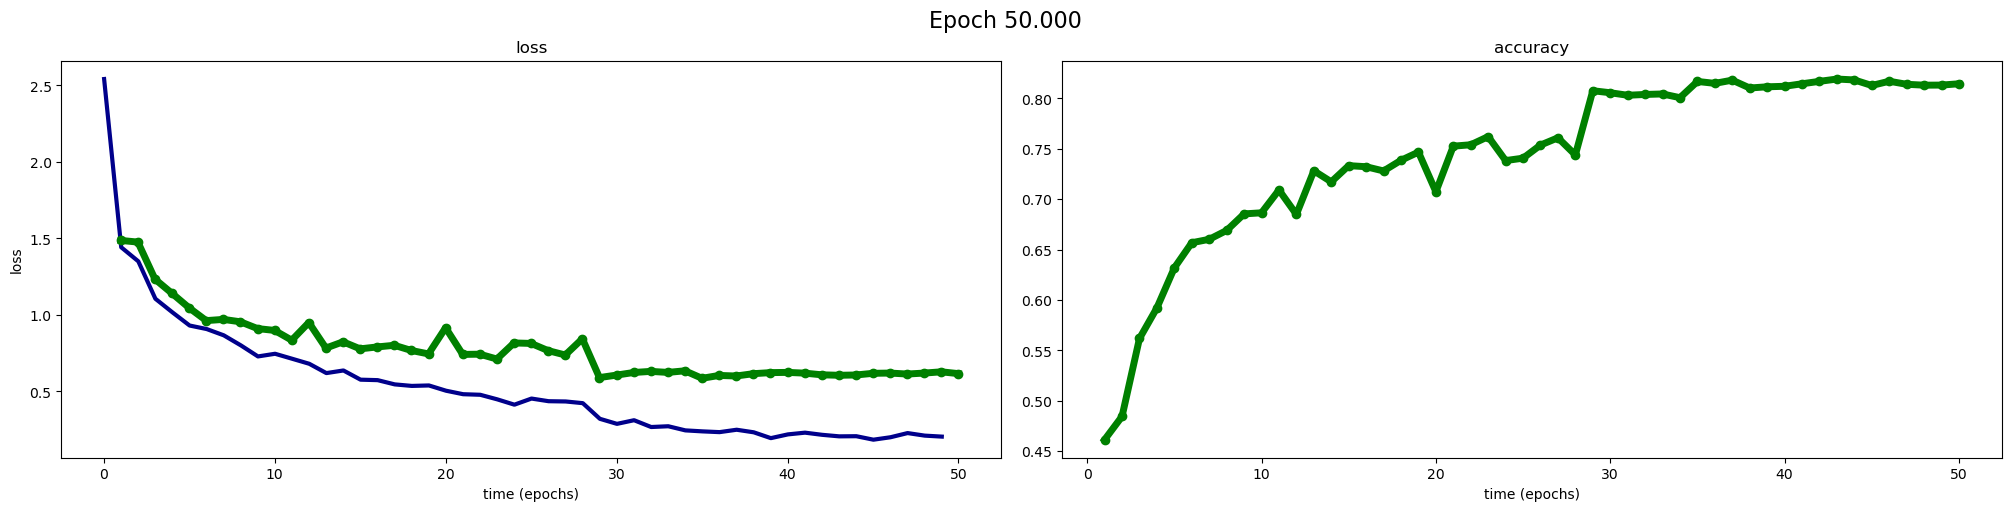

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:00:28<00:00, 72.57s/it]


In [ ]:
epochs = 50
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### добавим weight_decay - не сильно улучшилось, может чуть быстрее сошлось

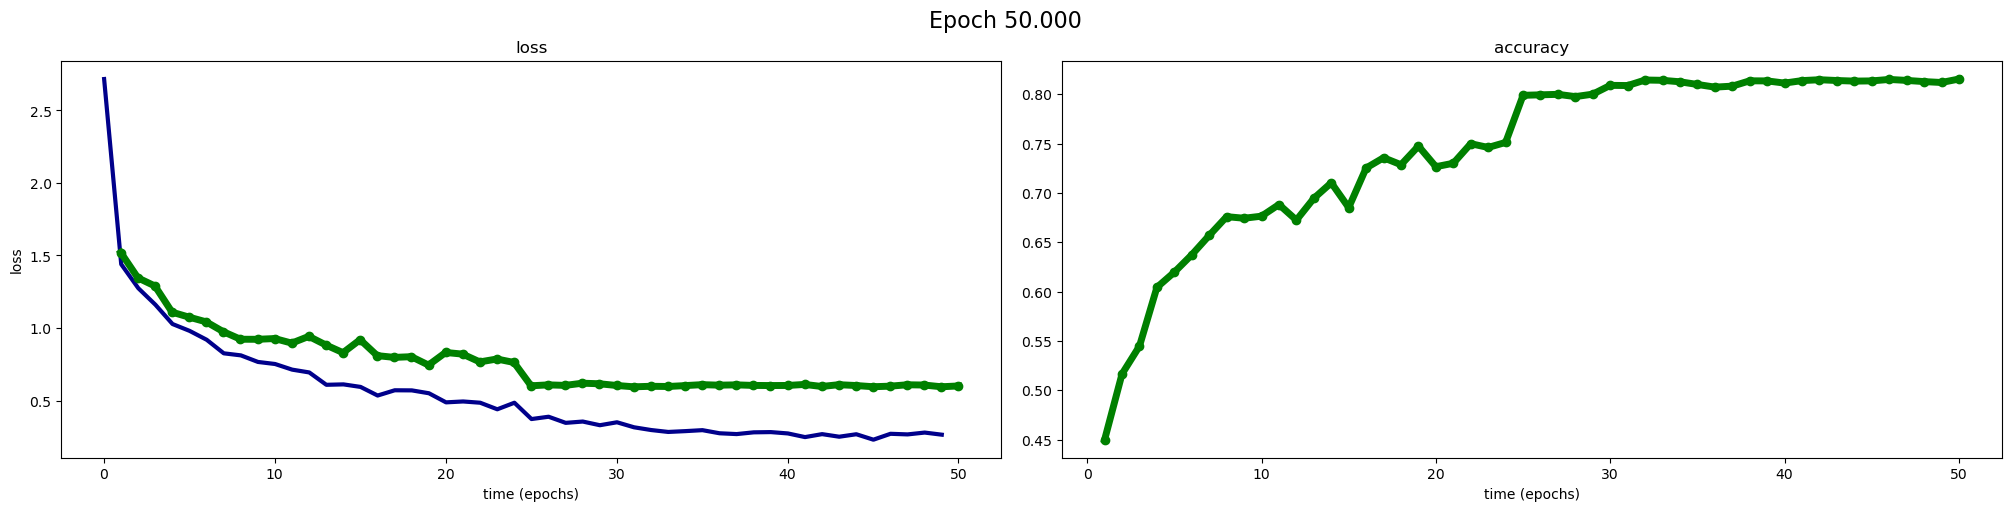

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [57:12<00:00, 68.66s/it]


In [ ]:
epochs = 50
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### добавим grad clip - ощутимой разницы нет

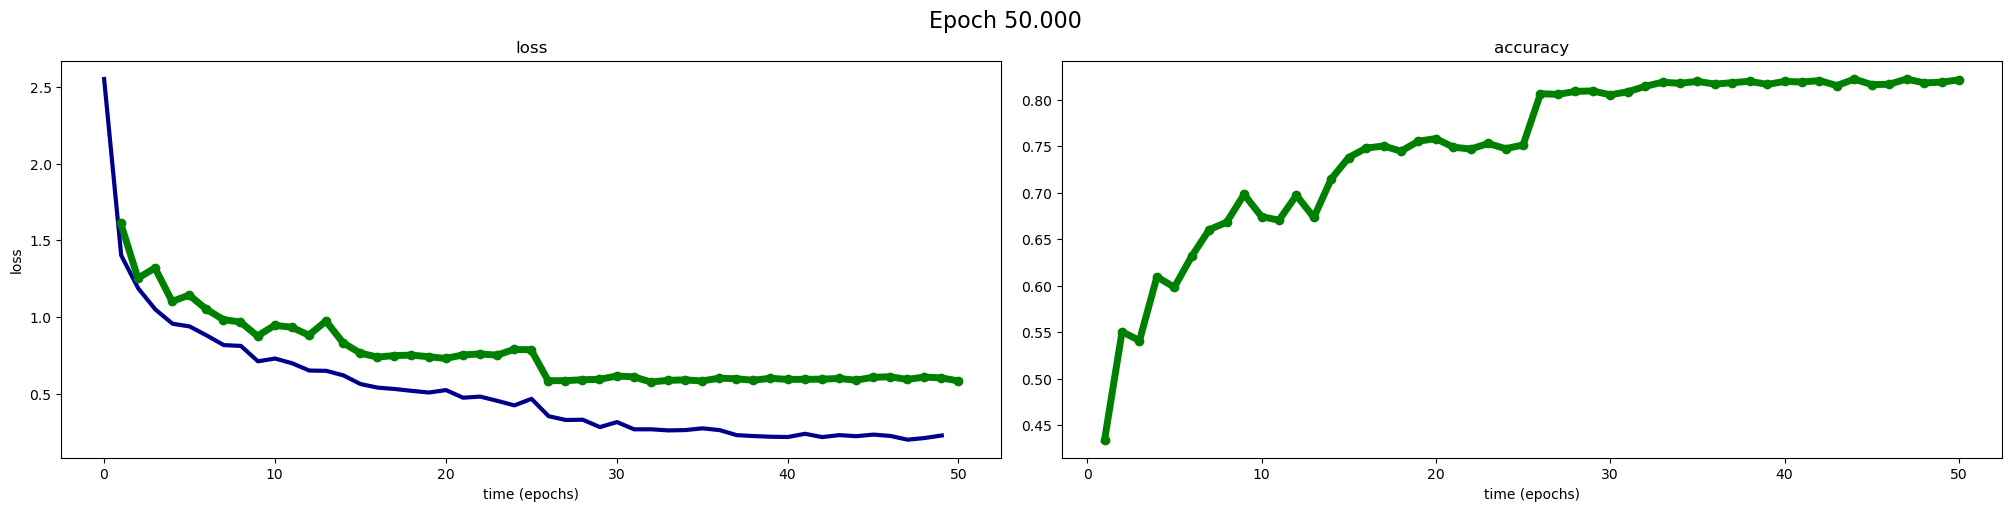

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [57:44<00:00, 69.28s/it]


In [ ]:
epochs = 50
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### решил добавить еще трансформов, но стало хуже

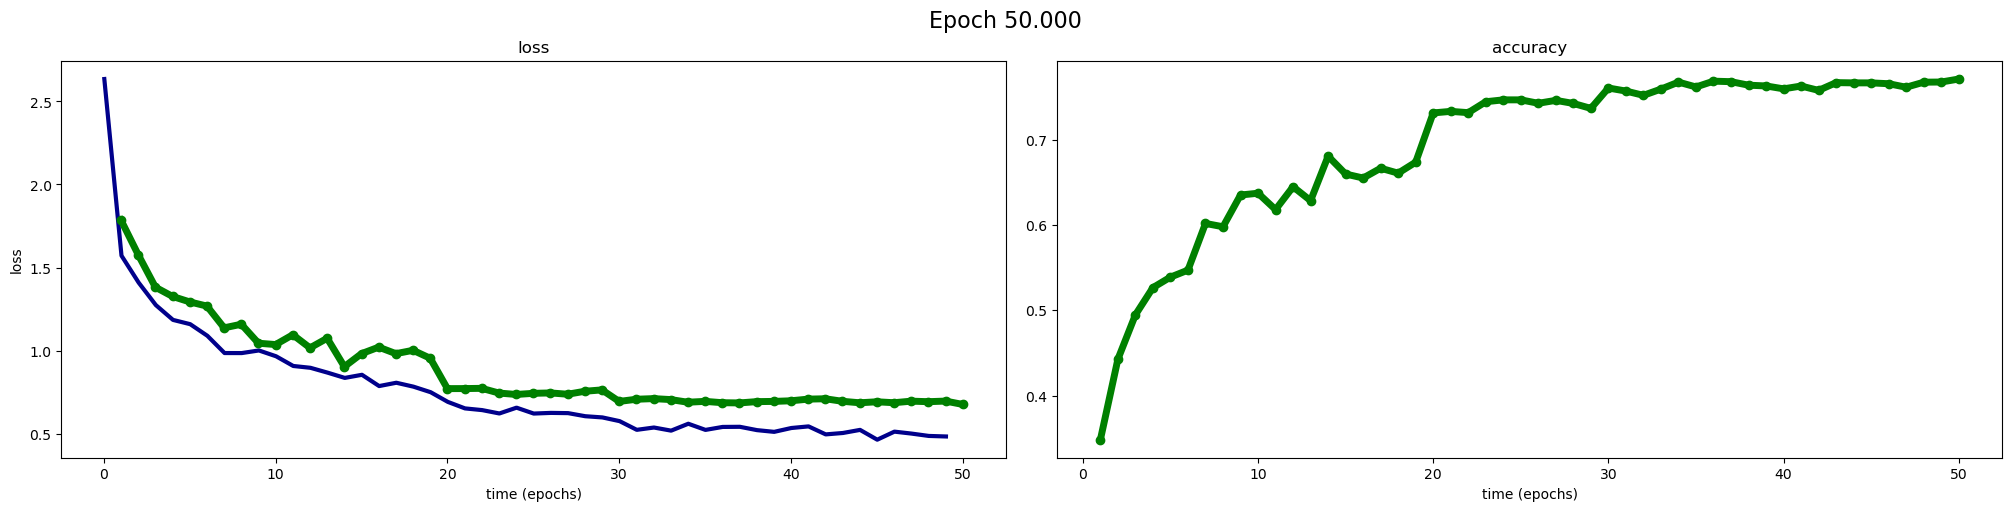

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:08:46<00:00, 82.53s/it]


In [ ]:
epochs = 50
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### уберем доп трансформы и град клип, попробуем с ELU - было лучше

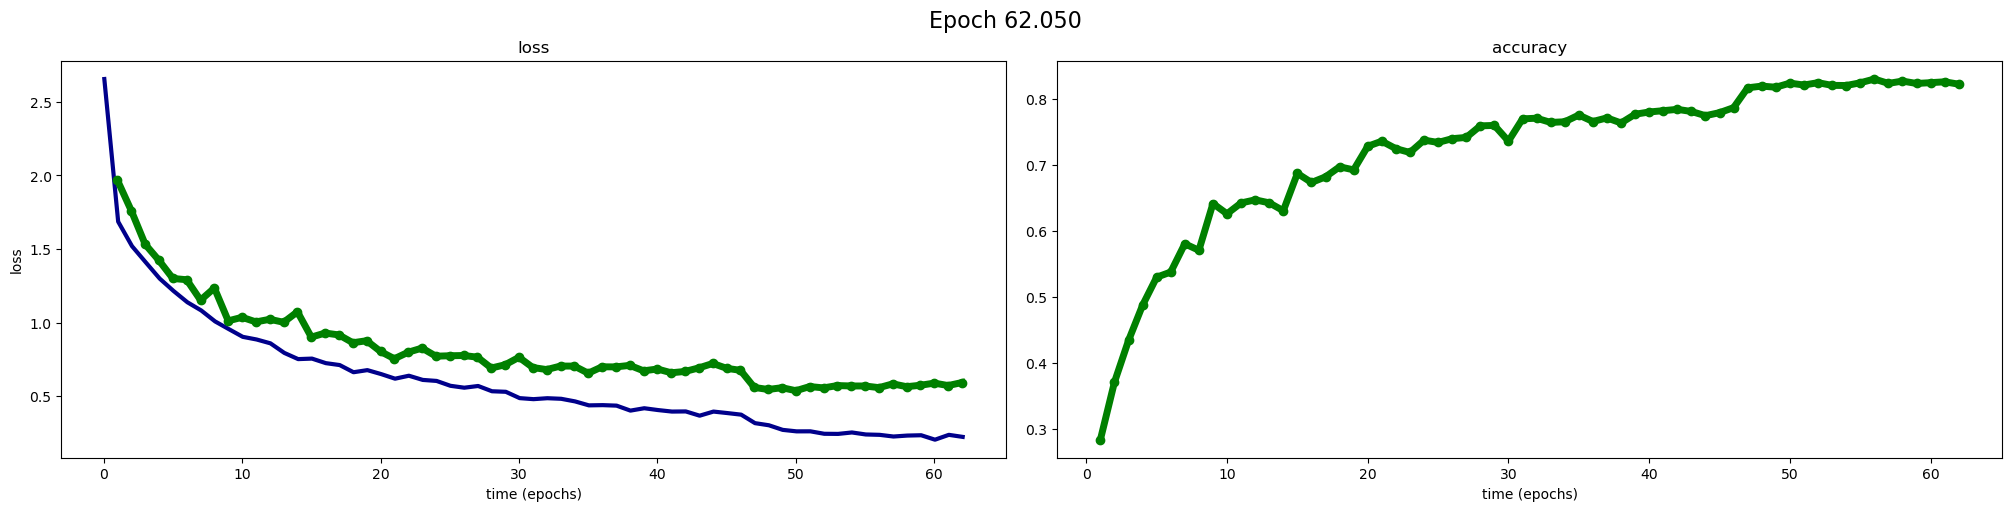

 41%|███████████████████████████████▊                                             | 62/150 [1:06:42<1:34:41, 64.56s/it]


KeyboardInterrupt: 

In [ ]:
epochs = 150
for t in trange(epochs):
    print(f'epoch {t}')
    train(t, train_dataloader, model, loss_fn, optimizer)
    test(t, val_dataloader, model, loss_fn)

### изменение начального lr, изменение типа шедулера и оптимайзера результат не улучшили. На этом моменте я решил, что, возможно, получил максимум из resnet18, и решил увеличить глубину.

### но обучать в этом же ноутбуке было неудобно, поэтому продолжение [тут](https://colab.research.google.com/drive/16cl_wKQVQUGDi0YHW09oJQ5R1dxaO8Cb?usp=sharing)

### Отправка решения

Загружаем часть датасета для теста.

In [ ]:
def transform_test(img):
    return tr.Compose([
        tr.ToTensor(),
        tr.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])(img)

In [ ]:
test_data = CIFAR10(
    root=dataset_root,
    train=False,
    transform=transform_test
    #transform=ToTensor(),
)

In [ ]:
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
)

Делаем предсказания итоговой моделью.

In [ ]:
predictions = []

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        pred = model(X).argmax(1).cpu().numpy()
        predictions.extend(list(pred))

In [ ]:
predictions[:10]

[7, 8, 7, 9, 1, 3, 4, 0, 6, 0]

Формируем файл решения для отправки в kaggle.

In [ ]:
def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)

write_solution('solution.csv', predictions)